/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/Users/yanyancheng/opt/anaconda3/envs/jnPython3.7.0_basemap/lib/python3.7/site-packages/ipyke

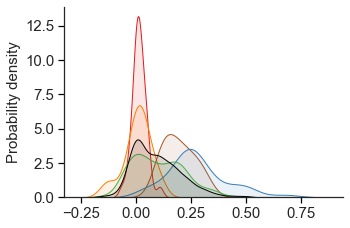

In [30]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import datetime
import csv
from netCDF4 import Dataset
from scipy import stats
from matplotlib import rc, rcParams

import seaborn as sns
plt.style.use('seaborn-ticks')
sns.set_context("notebook", font_scale=1.5)

title_size  = 17
marker_size = 7
stepsize    = 0.01
label_size  = 15
border_size = 1.0
tick_size   = 15
legend_size = 10
line_width  = 0.5
rotation    = 45
text_size   = 10
unit_size   = 11
box_width   = 0.22
box_linewidth=1
max_min_markersize=3
markersize=50
alpha=1.0

### read netcdf data
def read_data(fname,var):
    pt=Dataset(fname, 'r')
    data=pt.variables[var][:]
    return data

def mask_high_low_forest(forestdiff,data,sign):
    diff_threshold= 25.0     
    data=np.where(forestdiff<=diff_threshold, np.nan,data)
    return data

def fillmissing(data,missVal):
    data=np.where(data>=missVal, np.nan,data)
    return data

### fill missing values
def fill_missingVal(data,missVal):
    data=np.where(data>=missVal, np.nan,data)
    return data

def fillmissing_lucc(data):
    data=np.where(data>=1.00001, np.nan,data)
    data=np.where(data<0.0, np.nan,data)
    return data

### mask forest data, only remain those grids that LU at 2099 is >= 0.99
def remove_nandata(forest,data):
    data=data[~np.isnan(forest)]
    return data
    
def subplot_pair(paras1,paras2,paras3,paras4,paras5,paras6,paras7):
    fig, axs = plt.subplots(figure_rows, figure_cols, figsize=(figure_width,figure_length))
    sns.despine(left=False,bottom=False)
    
    plt.rcParams["axes.labelsize"] = label_size
    plt.rcParams["axes.titlesize"] = label_size
    plt.rcParams["xtick.labelsize"] = label_size
    plt.rcParams["ytick.labelsize"] = label_size
    plt.rcParams["legend.fontsize"]=label_size
    rc('font', style='normal')
    rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \italicmath']
    
    ax=axs
    ylabel = "Probability density"
    alpha=0.1
    plot_hist = False
     
    color1,color2,color3,color4,color5,color6,color7="#e41a1c","#984ea3","#ff7f00",\
              "#a65628","#377eb8","#4daf4a","k"
    var="dC/df (kg C/m$^2$/%)\n(2100 vs. 2015)"
    sns.distplot(paras1, hist=plot_hist, color=color1,axlabel=var, \
                 kde_kws={"shade": True,"alpha": alpha},ax=ax)
    sns.distplot(paras3, hist=plot_hist, color=color3,axlabel=var, \
                 kde_kws={"shade": True,"alpha": alpha}, ax=ax)
    sns.distplot(paras4, hist=plot_hist, color=color4,axlabel=var, \
                 kde_kws={"shade": True,"alpha": alpha}, ax=ax)
    sns.distplot(paras5, hist=plot_hist, color=color5,axlabel=var, \
                 kde_kws={"shade": True,"alpha": alpha}, ax=ax)
    sns.distplot(paras6, hist=plot_hist, color=color6,axlabel=var, \
                 kde_kws={"shade": True,"alpha": alpha}, ax=ax)
    sns.distplot(paras7, hist=plot_hist, color=color7,axlabel=var, \
                 kde_kws={"shade": True,"alpha": alpha}, ax=ax)
    
    ax.set(xlabel="delta VegC", ylabel=ylabel)
    ax.tick_params(axis='both', which='major', labelsize=tick_size,color="k")
    ax.set_xlabel("",fontsize=label_size,fontstyle="normal")
    ax.set_ylabel(ylabel,fontsize=label_size,fontstyle="normal")
        
    fig.patch.set_facecolor("white")
    fig.patch.set_alpha(0.0)
    fig_dir = "../figures/"
    bname = "Fig3d"
    figname=fig_dir+bname+'.pdf'
    os.system("rm -f "+figname)
    plt.savefig(figname,bbox_inches='tight')

def read_one_ensemble(caseid):
    fname=data_dir +var+"_SSP126Lu-REFOREST_"+caseid+"_2015_2100.nc"
    data = read_data(fname, "value")
    data = data[-1,:,:]-data[0,:,:]
    data=fill_missingVal(data,1e36)
    data[data==0] = np.nan
    vegc=data/1000. #convert gC/m2 to kgC/m2
    return vegc
    
def subplot(sign,crop,lat_var_b, lat_var_e, lon_var_b, lon_var_e,region):
    ensbase=np.empty((ens_size,192,288))
    for caseid,i in zip(["ensemble1","ensemble2","ensemble3"],np.arange(ens_size)):
        ensbase[i,:,:] = read_one_ensemble(caseid)
    vegc = np.nanmean(ensbase,axis=0)

    ### read forest fraction
    if (sign == "sigreforestation"):
        lastyr = "2060"

    else:
        lastyr = "2100"
            
    fname=data_dir+crop+"_frac_2015_SSP126Lu-REFOREST.nc"
    firstyr_forest = read_data(fname, "biofrac") * 100.
    fname=data_dir+crop+"_frac_"+lastyr+"_SSP126Lu-REFOREST.nc"
    lastyr_forest = read_data(fname, "biofrac") * 100.
    
    forestfrac=lastyr_forest-firstyr_forest
    
    forestdiff=lastyr_forest-firstyr_forest
    
    ### do not consider deforestation
    vegc = np.where(forestdiff<=0.0005, np.nan,vegc)
    plotval = vegc/forestdiff
    
    nlat_b=int((lat_var_b-beglat)/step_lat)
    nlon_b=int((lon_var_b-beglon)/step_lon)
    nlat_e=int((lat_var_e-beglat)/step_lat)
    nlon_e=int((lon_var_e-beglon)/step_lon)

    if (region != "global"):
        forestdiff = forestdiff[nlat_b:nlat_e,nlon_b:nlon_e]
        plotval = plotval[nlat_b:nlat_e,nlon_b:nlon_e]
    
    nlat,nlon=np.shape(forestdiff)[0],np.shape(forestdiff)[1]
    
    forestdiff = forestdiff.reshape(nlat*nlon)
    plotval = plotval.reshape(nlat*nlon)
    
    vegc_forplot = mask_high_low_forest(forestdiff,plotval,sign)
                    
    return vegc_forplot

################
## plot figure, time series
################
figure_width=5
figure_length=3.5
figure_rows = 1
figure_cols = 1

data_dir= "../data/"

ens_size=3
yearstring="_86years"
var = "TOTECOSYSC"

years=np.arange(2015,2105,5)
indexs=np.arange(len(years))
yeari_dic={ivar: ivar_array for (ivar, ivar_array) in zip(years,indexs)}

crop="forest"

beglat=-90
endlat=90
beglon=-180
endlon=180

regions = ["Central US", "Central America","EU",\
               "SEA","Africa","South America","global"]
beglats = [32,7,35,\
           -5,-10,-55,-90]
endlats = [45,18,45,\
           20,5,10,90]
beglons = [-115,-92,10,\
           95,10,-85,-180]
endlons = [-95,-78,37,\
           130,30,-35,180]

step_lat = 0.94
step_lon = 1.25
sign = "sigreforestation"
for lat_var_b, lat_var_e, lon_var_b, lon_var_e,i,region in zip(beglats,endlats,beglons,\
                                                               endlons,np.arange(len(regions)),regions):
    paras=subplot(sign,crop,lat_var_b, lat_var_e, lon_var_b, lon_var_e,region)
    if (i==0):
        paras1=paras
    elif (i==1):
        paras2=paras
    elif (i==2):
        paras3=paras
    elif (i==3):
        paras4=paras
    elif (i==4):
        paras5=paras
    elif (i==5):
        paras6=paras
    elif (i==6):
        paras7=paras

subplot_pair(paras1,paras2,paras3,paras4,paras5,paras6,paras7)